# Introduction

Collagen diseases are a group of conditions that affect the connective tissues in the body, which provide structure and support to organs and tissues. These diseases can range from mild to severe and include conditions like lupus, rheumatoid arthritis, and scleroderma. In these diseases, thrombosis is one of the most important and severe complications, one of the major cause of death in collagen diseases. Recently, this complication is closely related with anti-cardiolipin antibodies, which was discovered by the medical physicians, one of whom donated the datasets for discovery challenge.

The seriousness of Thrombosis has made it one of the most important diseases being explored in the medical industry, for properly understanding it and potentially identifying its predictors would provide a breakthrough that made save thousands of lives. 

That being said, Georgetown University has provided me with data from their university hospital to conduct an analysis on thrombosis and its possible contributors. This data includes information on patient demographics, medical history, and laboratory results, which will be used to identify potential risk factors and underlying causes of thrombosis. 

The main objectives of this project are: <br><br>

* Identify potential predictors of Thrombosis.
* Analyze any potential temporal patterns associated with Thrombosis.
* Understand the characteristics of a patient with Thrombosis.

<br><br>
To achieve these objectives, the data will be carefully analyzed to identify any significant patterns and relationships that can provide insights into the causes and characteristics of Thrombosis. By doing so, this project aims to contribute to a better understanding of Collagen diseases, particularly Thrombosis, and ultimately improve the diagnosis and treatment of these life-threatening conditions.


# Data Summary


The Hospital has provided with 3 main datasets, brief descriptions of each can be found below: <br><br>

* tsumoto_a.csv: Basic Information about Patients<br>
* tsumoto_b.csv: Special Laboratory Examinations <br>
* tsumoto_c.csv: Laboratory Examinations stored in Hospital Information Systems<br> <br>

Before doing any kind of analysis, it is important to properly understand the datasets in terms of shape, strengths, weaknesses, etc. <br><br>

Importing all necessary libraries.

In [1]:
# Importing all necessary packages
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import klib
import missingno as msno
from sklearn.preprocessing import StandardScaler
from math import pi
from wordcloud import WordCloud, STOPWORDS
import sys

Importing the 3 datasets. As a quick note, a couple of lines in tsumoto_C were causing issues when reading the dataset, so a "error_bad_lines=False" argument was introduced to bypass these issues. A total of 30 lines (out pf 50k + where dropped), so any impacts of this drop would be very minimal.

In [2]:
# Redirect stdout and stderr to null device
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

# Importing datasets
df_A = pd.read_csv("data/TSUMOTO_A.csv" , encoding='ISO-8859-1')
df_B = pd.read_csv("data/TSUMOTO_B.csv" ,  encoding='ISO-8859-1')
df_C = pd.read_csv("data/TSUMOTO_C.csv" , encoding='ISO-8859-1' , error_bad_lines=False) 
# A couple of bad (unreadable) lines in tsumoto_c where dropped. The dropped lines account for 30 (out of 50k+),
# which makes this drop insignificant

Quick look at each data set:

In [3]:
df_A.head(5)

,ID,SEX,Birthday,Description,First Date,Admission,Diagnosis
0,2110,F,1934/2/13,94.02.14,93.02.10,+,RA susp.
1,11408,F,1937/5/2,96.12.01,73.01.01,+,PSS
2,12052,F,1956/4/14,91.08.13,NaN,+,SLE
3,14872,F,1953/9/21,97.08.13,NaN,+,MCTD
4,27654,F,1936/3/25,NaN,92.02.03,+,"RA, SLE susp"


In [4]:
df_B.head(5)

,ID,Examination Date,aCL IgG,aCL IgM,ANA,ANA Pattern,aCL IgA,Diagnosis,KCT,RVVT,LAC,Symptoms,Thrombosis
0,14872.0,1997/5/27,1.3,1.6,256,P,0.0,"MCTD, AMI",NaN,NaN,-,AMI,1
1,48473.0,1992/12/21,4.3,4.6,256,"P,S",3.3,SLE,-,-,-,NaN,0
2,102490.0,1995/4/20,2.3,2.5,0,NaN,3.5,PSS,NaN,NaN,NaN,NaN,0
3,108788.0,1997/5/6,0.0,0.0,16,S,0.0,NaN,NaN,NaN,-,NaN,0
4,122405.0,1998/4/2,0.0,4.0,4,P,0.0,"SLE, SjS, vertigo",NaN,NaN,NaN,NaN,0


In [5]:
df_C.head(5)

,ID,Date,GOT,GPT,LDH,ALP,TP,ALB,UA,UN,...,C3,C4,RNP,SM,SC170,SSA,SSB,CENTROMEA,DNA,DNA-II
0,2110,860419,24,12,152,63,7.5,4.5,3.4,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2110,860430,25,12,162,76,7.9,4.6,4.7,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2110,860502,22,8,144,68,7,4.2,5,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2110,860506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2110,860507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


At first glance, the datasets seem to have a couple of missing values, something which will be dealt with later on.

In [6]:
"Lenght of df_A: " + str(df_A.shape)

'Lenght of df_A: (1240, 7)'

In [7]:
"Lenght of df_B: " + str(df_B.shape)

'Lenght of df_B: (806, 13)'

In [8]:
"Lenght of df_C: " + str(df_C.shape)

'Lenght of df_C: (57510, 44)'

The lengths of the data sets makes sense considering their nature, where tsumoto_C is by far the largest one considering it is for general laboratory examinations, where each user has more than one entry (multiple examinations per user).

Before moving on with any analysis, renaming the columns to make the dataset tidier is a good idea. The idea is to have all columns in lower case and with "_" (underscore) instead of spaces.

In [9]:
def rename_columns(df):
    for i in range(len(df.columns)):
        if len(df.columns[i].split()) != 1:
            df.rename(columns={str(df.columns[i]): (str(df.columns[i]).lower().split()[0]) + '_' + (str(df.columns[i]).lower().split()[1])}, inplace=True)
        else:
            df.rename(columns={str(df.columns[i]):str(df.columns[i]).lower()}, inplace=True)

    

rename_columns(df_A)
rename_columns(df_B)
rename_columns(df_C)

Fix a couple of columns in the dataframe.

In [10]:
def format_date_column(df, col_name):
    formatted_dates = []
    for date in df[col_name]:
        y = str(date)[0:2]
        m = str(date)[2:4]
        d = str(date)[4:6]
        formatted_dates.append('19' + y + '/' + m + '/' + d)
    df[col_name] = formatted_dates
    return df

df_C = format_date_column(df_C, 'date')

A huge part of this project focuses on joining these data sets and subsets of these datasets, so checking for the missing values per column (per data set) would give a good sense of what columns are useless and should be possibly dropped.

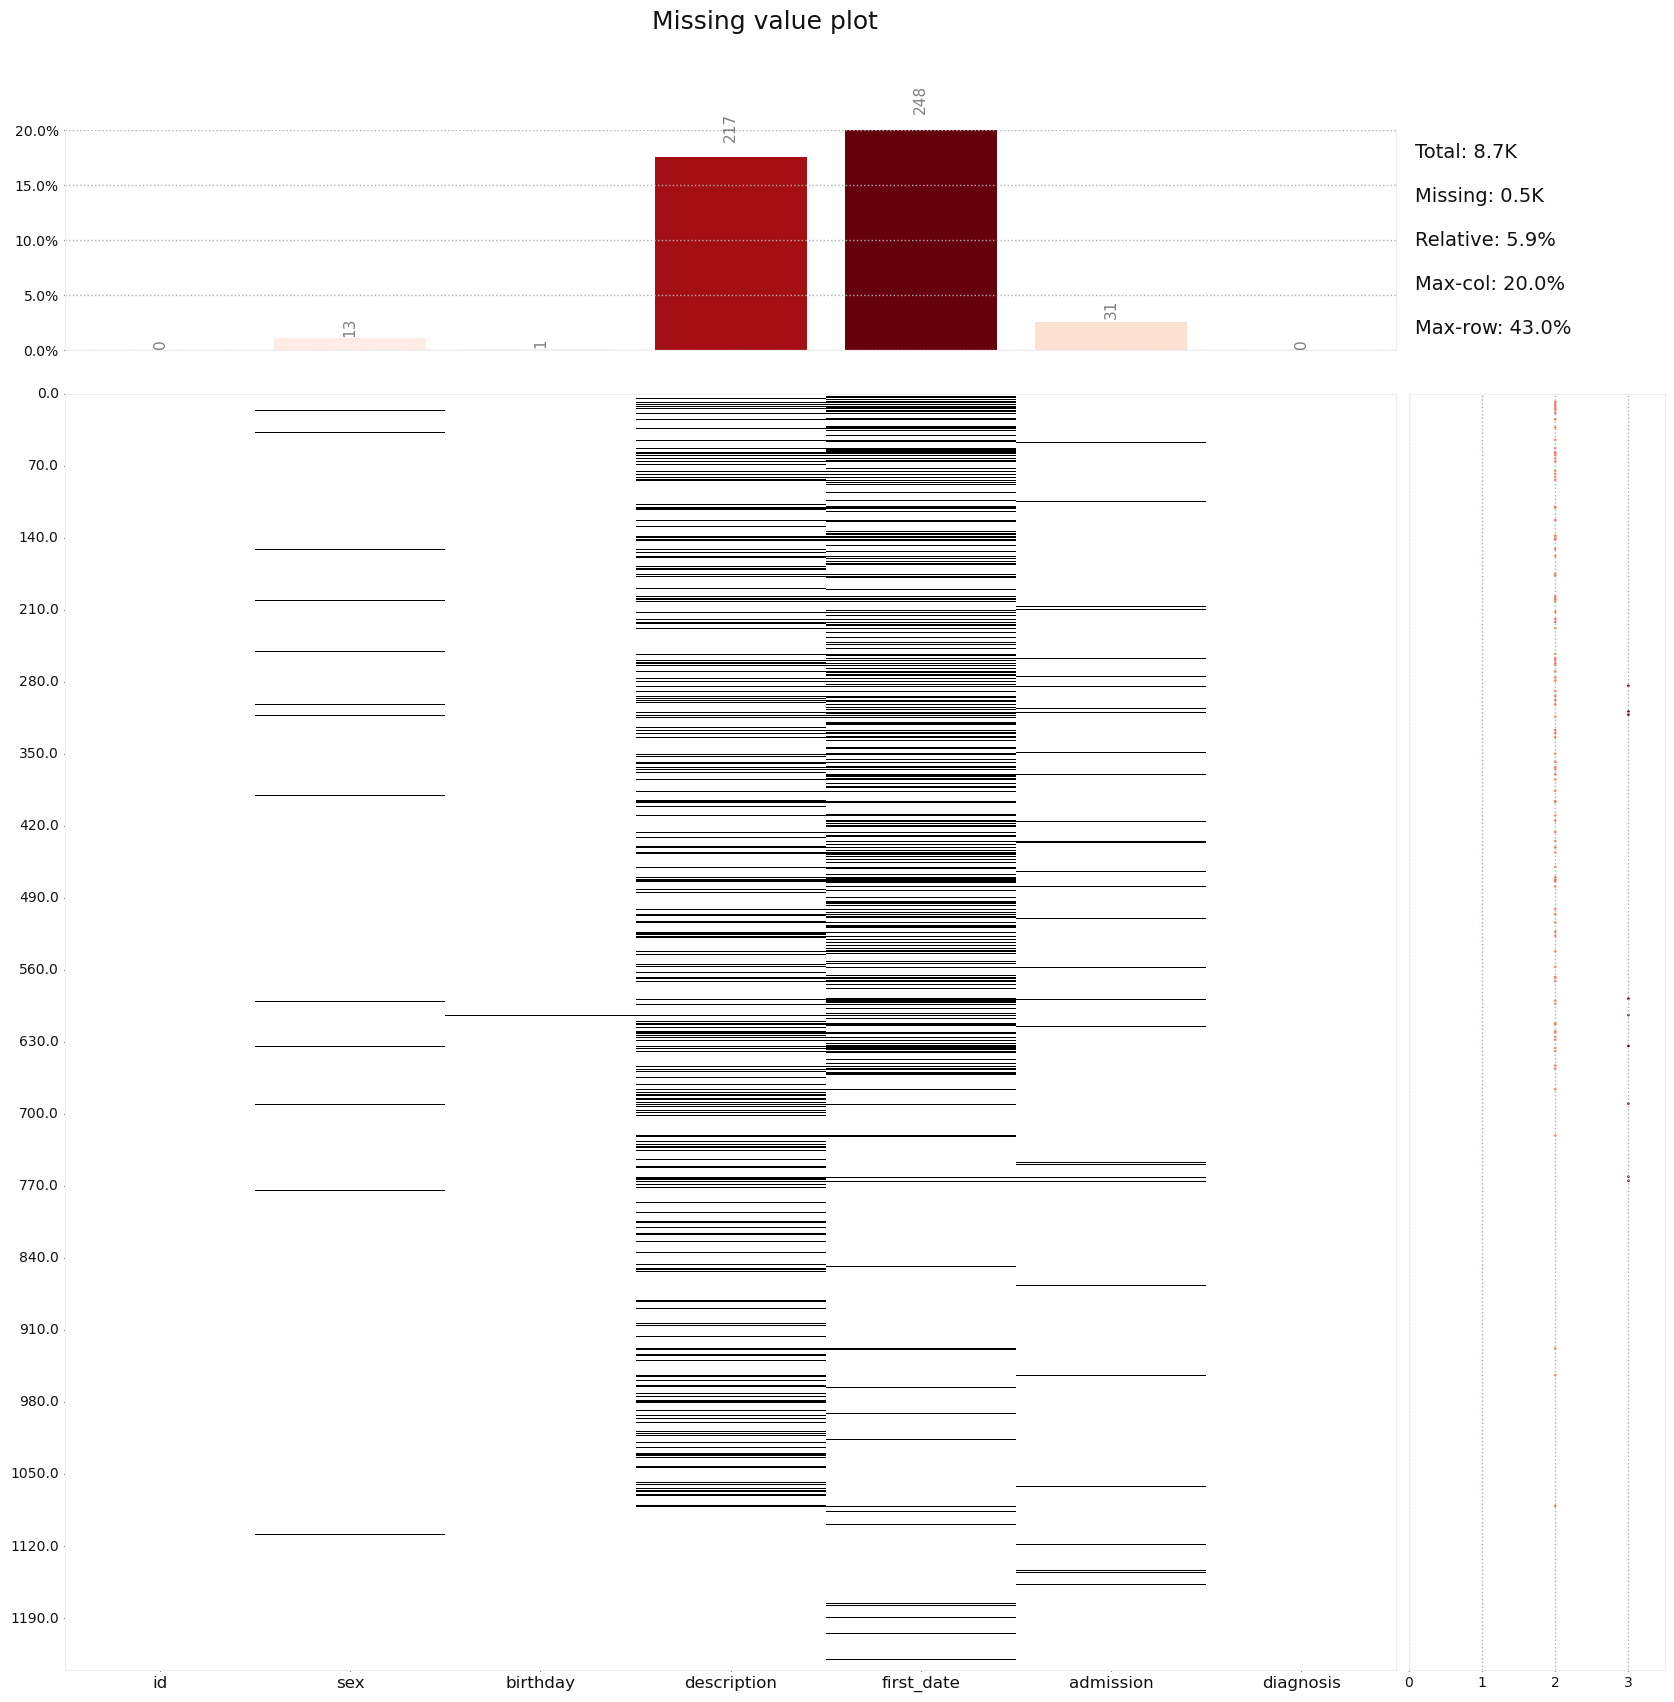

<Figure size 800x600 with 0 Axes>

In [11]:
# Missing values plot df_A

# Redirect stdout and stderr to null device
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

klib.missingval_plot(df_A , cmap='Reds')
plt.figure(figsize=(8, 6))
plt.show()

All columns in df_A seem fine, description and first date (date of admission) are the columns with the highest rate of missing values (15% and 20%), but that shouldnt cause any troubles. Dealing with missing values in these columns could be dealt with at later stages, when/if they are used.


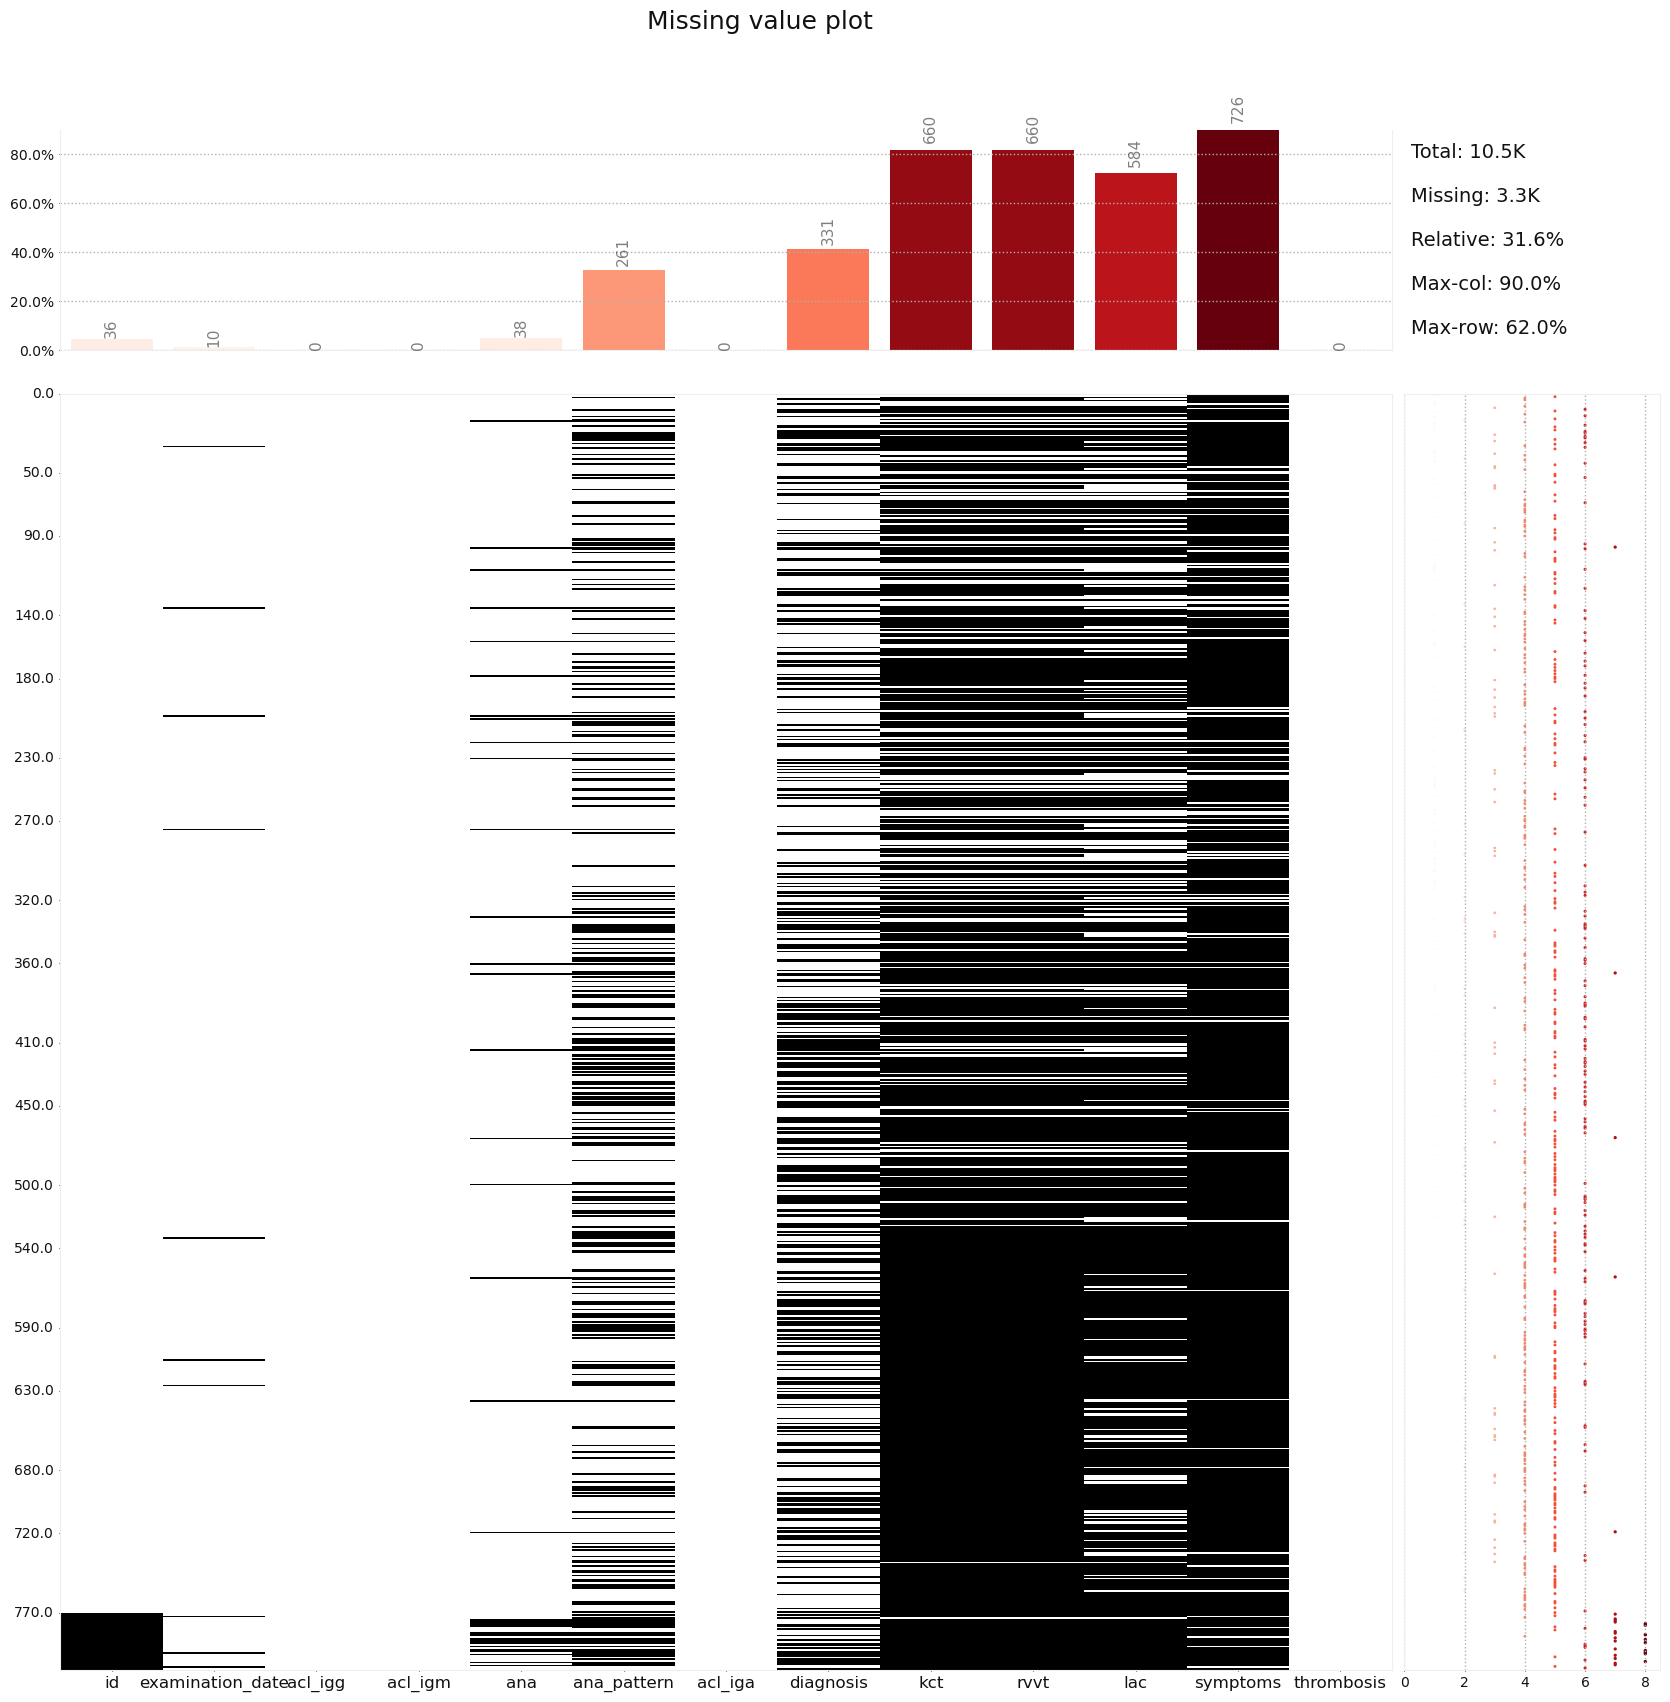

<Figure size 800x600 with 0 Axes>

In [12]:
# Missing values plot df_A

# Redirect stdout and stderr to null device
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

klib.missingval_plot(df_B, cmap='Reds')
plt.figure(figsize=(8, 6))
plt.show()

It appears that df_B is more concerning than df_A as it contains 4 columns with more than 70% (some even 80%) of the values missing. These columns, namely kct, rvvt, lac, and symptoms, pose a significant challenge in terms of replacing missing values due to various reasons. Since only around 20% of the columns have values, it's difficult to determine how the missing values are distributed and how they might impact the data. Attempting to replace these missing values would introduce bias and skewness in the data, leading to results that may not accurately represent reality. Therefore, the best course of action would be to drop these columns and exclude them from further analysis.


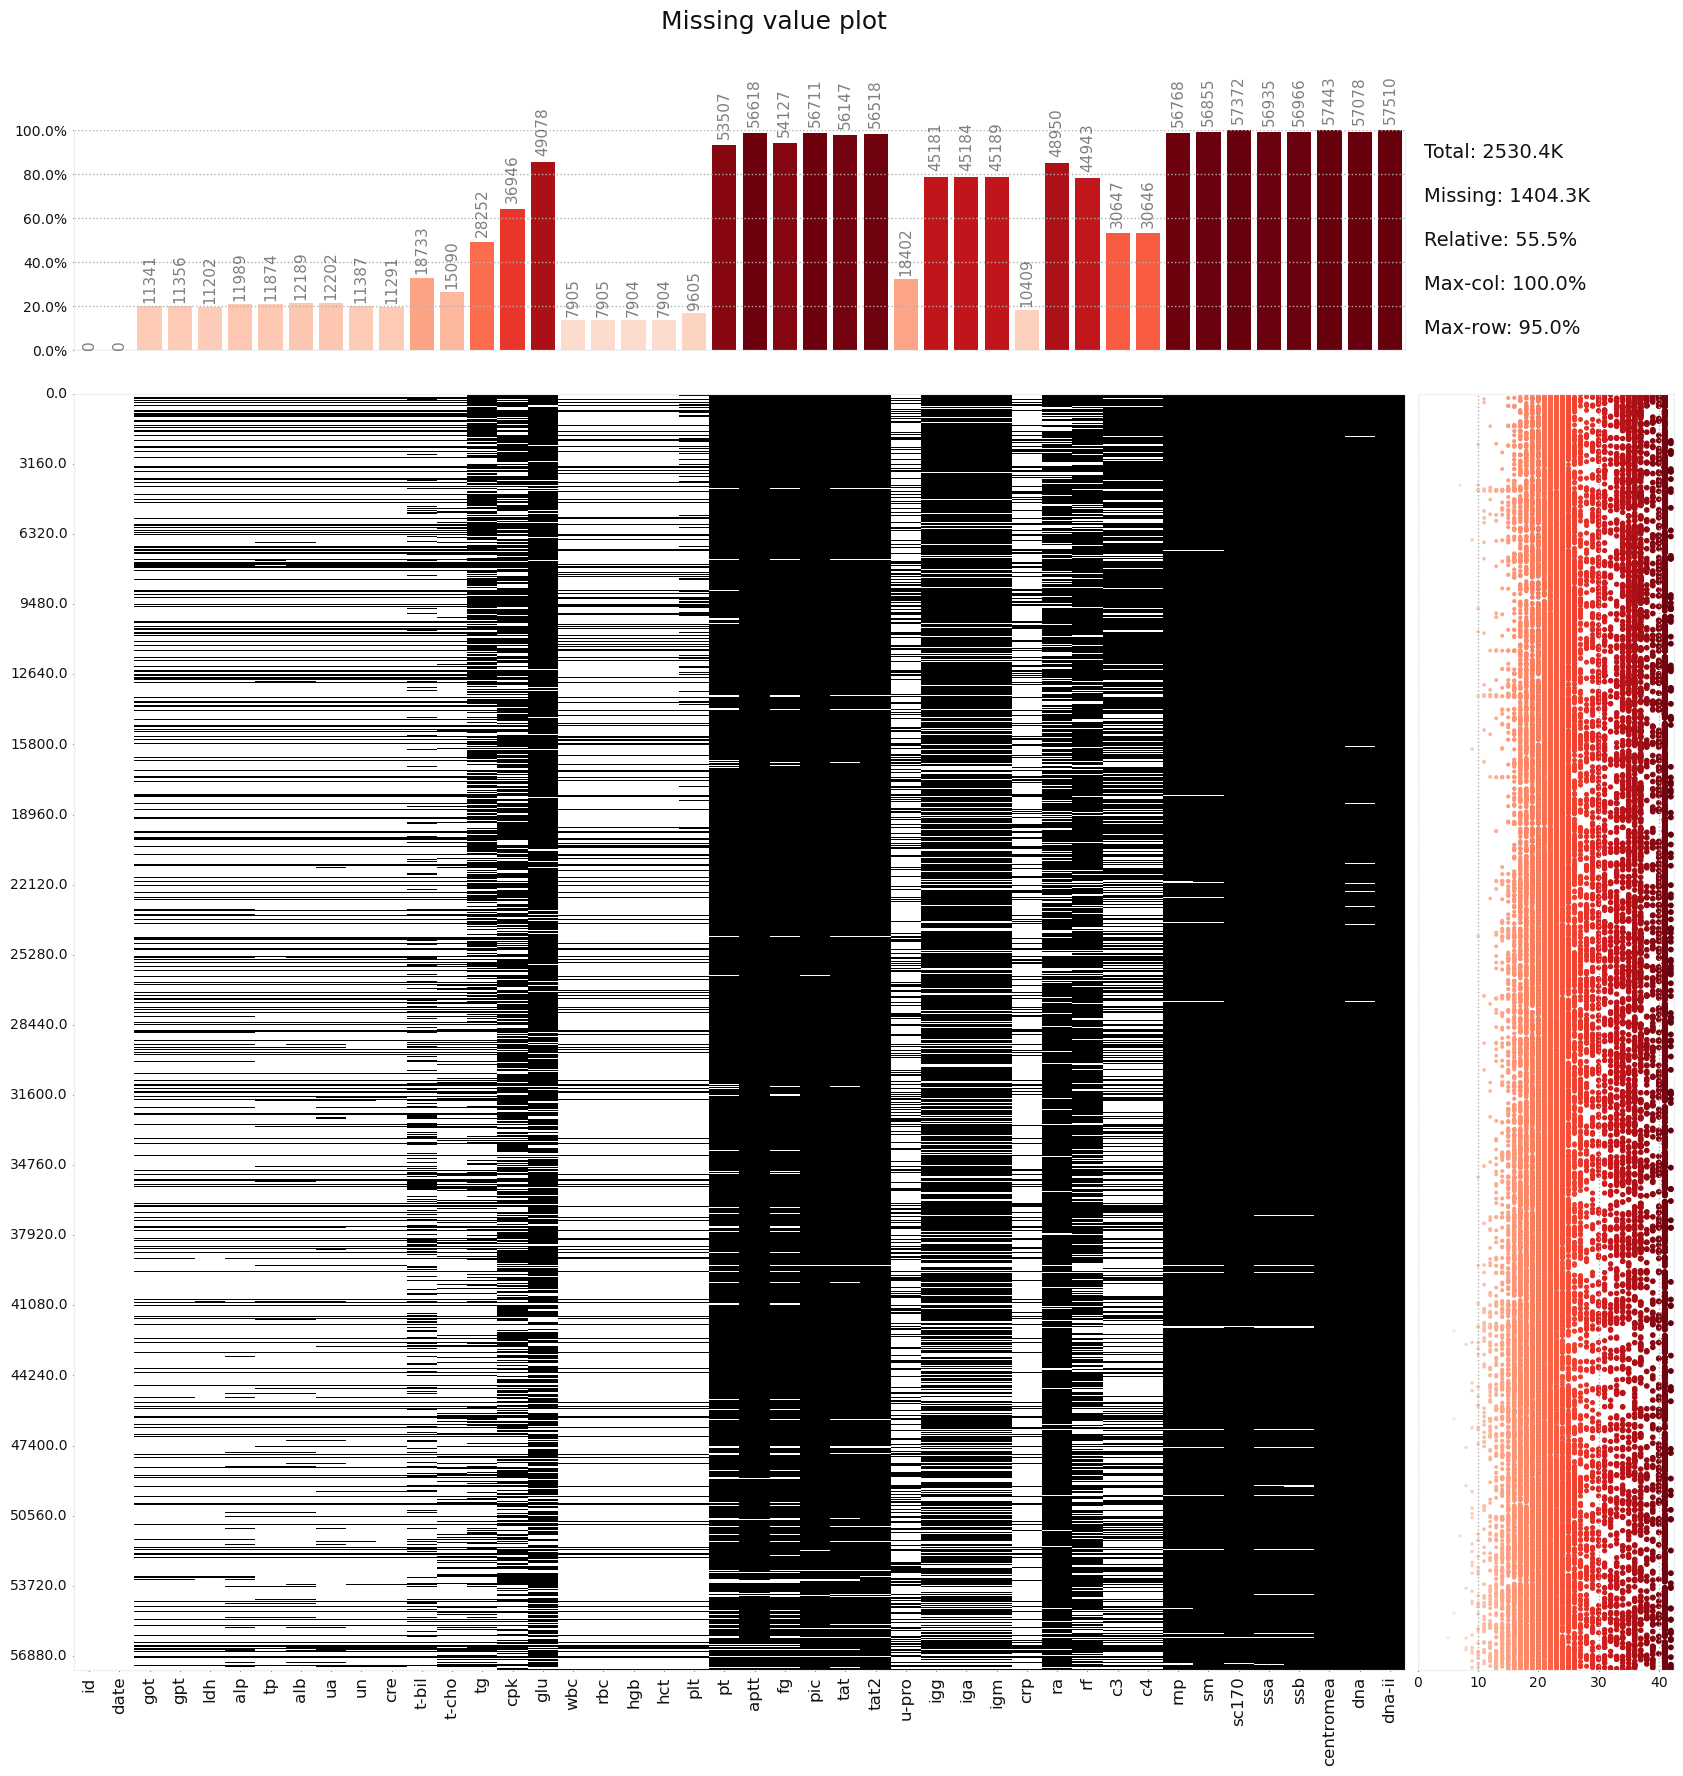

<Figure size 800x600 with 0 Axes>

In [13]:
# Missing values plot df_A


# Redirect stdout and stderr to null device
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

klib.missingval_plot(df_C, cmap='Reds')
plt.figure(figsize=(8, 6))
plt.show()

As for df_C, which turns out to be the most torubling dataset, with almost haf (19 out of 44) of the columns have more than 60% as missing values, of which 15 columns have more than 80% missing values. The main issue is that the majority of these columns are numeric and could have added context to any possible analysis, but the current state of the columns make them useless and very troublesome.

To further understand the reaso behind that much missing data, i will plot missing values correlation heatmaps, which show which variables usually are missing together and the possible implications. 


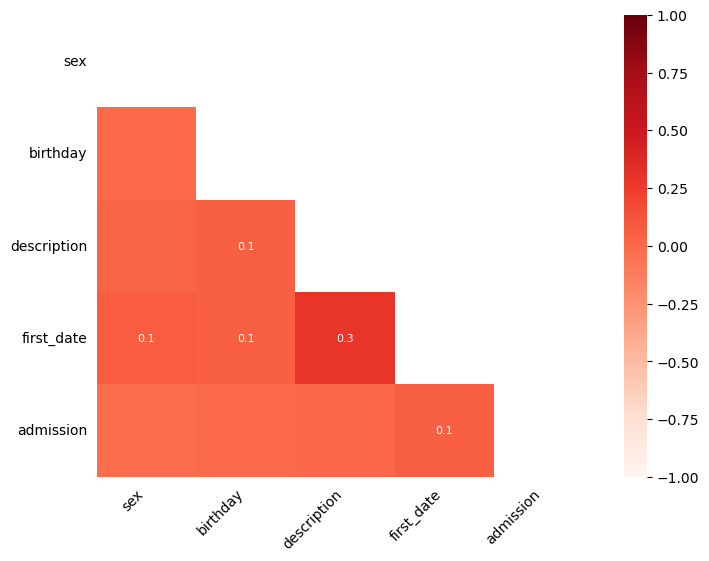

In [14]:
# Missing value correlations df_A

# Redirect stdout and stderr to null device
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

mva = msno.heatmap(df_A, cmap='Reds', figsize=(8, 6) , fontsize = 10)

Nothing too significant for df_A.

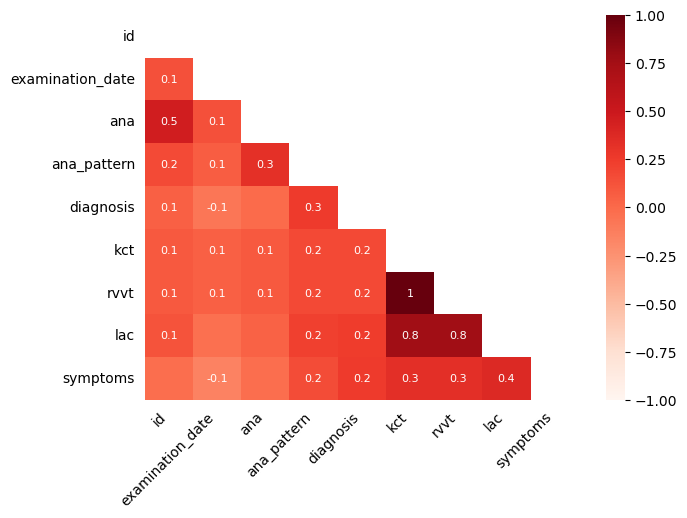

In [15]:
# Missing value correlations df_B

# Redirect stdout and stderr to null device
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

mva = msno.heatmap(df_B, cmap='Reds', figsize=(7, 5) , fontsize = 10)

The only significant missing values relationship/correlation are between kct and lac as well as rvvt and lac, which makes sense considering they are the same thing (measure of degree of coagulation). Two of these three columns should be dropped considerig they represent the same thing.


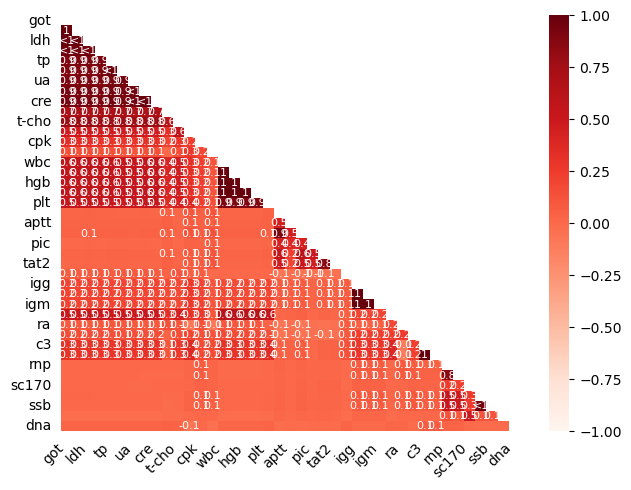

In [16]:
# Missing value correlations df_C

# Redirect stdout and stderr to null device
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

mva = msno.heatmap(df_C, cmap='Reds', figsize=(7.4, 5.4) , fontsize = 10)

The upper half of the above missing values correlation plot is full of correlations in the 0.7-1 range, which could be explained in 2 ways:  

* There is a lot of missing values in many columns, leading to a high missing values correlation. 
* Most of these lab test results are done together (same test) and hence skipping one test would impact many results. For example, tp and got (correlation 0.9) could be resulting from the same test.

The above hypotheses would be further understood once missing values are dropped and new heatmaps are plotted, which is part of the next steps. 


Finally, since one of the main goals of the research project was understand Thrombosis at a deeper level, it is important to see how many cases are present in the dataset and how they evolved over time.

Text(0, 0.5, 'Count')

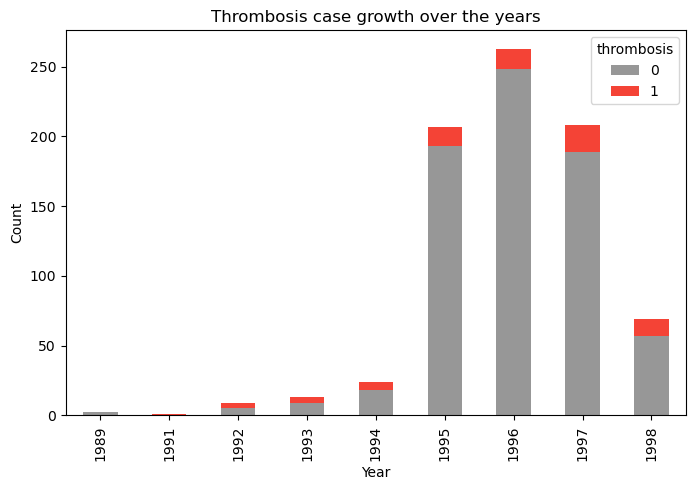

In [17]:
# Temporal Analysis (How has thrombosis evolved over time)


temporal_B = df_B.dropna(subset=['examination_date' , 'thrombosis'])
temporal_B = temporal_B.sort_values(by=['examination_date'])
temporal_B['examination_date'] = pd.to_datetime(temporal_B['examination_date'])


# Replace thrombosis 2 and 3 with 1, since we want to analyze thrombosis in general 
temporal_B['thrombosis'] = temporal_B['thrombosis'].replace({2: 1, 3: 1})



# Extract the year from the datetime and create a new column
temporal_B['year'] = temporal_B['examination_date'].dt.year

thrombosis_counts = temporal_B.groupby('year')['thrombosis'].value_counts()
 
thrombosis_counts = temporal_B.groupby('year')['thrombosis'].value_counts().unstack()


ax = thrombosis_counts.plot(kind='bar', stacked=True, figsize=(8, 5), color=
['#979797', '#f44336'])
ax.set_title("Thrombosis case growth over the years")
ax.set_xlabel('Year')
ax.set_ylabel('Count')

The bar chart above showcases a big issue with the data, there are very few Thrombosis patients (and even less level 2 and level 3 patients) which could lead to inaccurate conclisons about the disease. For example, if i were to analyze the average IGA of Thrombosis level 3 patients but there are only 6 patients in that category, the results might be very far from the population (All thrombosis level 3) average. This is just a quick example of how this could cause issues, so it is important to highlight this limitation before moving forward with any analysis.


# Initial Questions

* Does Age have any impact on Thrombosis ?
* Is Thrombosis more prevalent in Males compared to Females (or vice versa) ?
* What are the possible Laboratory tests that could help in predict Thrombosis ?
* Are there any prevalent symptoms a person experiences when they have Thrombosis ?


# Data Munging

As previously discussed, missing values are a big obstacle to the data sets, so dealing with them is a priority before carrying on any analysis. The first rule/assumption i decided on is drop any columns with more than 70% missing values, as the potential bias and skeweness introduced by data imputation is not worth it. Columns closes to the 50-60% missing values will be kept and evaluated on a case by case basis.

In [18]:
 df_A = df_A.loc[:, df_A.isna().mean() < 0.7]
 df_B = df_B.loc[:, df_B.isna().mean() < 0.7]
 df_C = df_C.loc[:, df_C.isna().mean() < 0.7]


Check new column dimensions (after dropping columns)

In [19]:
"Lenght of modified df_A: " + str(df_A.shape)

'Lenght of modified df_A: (1240, 7)'

In [20]:
"Lenght of modified df_B: " + str(df_B.shape)

'Lenght of modified df_B: (806, 9)'

In [21]:
"Lenght of modified df_C: " + str(df_C.shape)

'Lenght of modified df_C: (57510, 24)'

In terms of joining data sets, there are multiple ways of doing so. depending on the question being answered. The first set of questions and analysis i want to do is on Thrombosis itself, understanding how prevalent it is, what are its main symptoms, what might be some predictors, etc.

For that reason, the primary unit of observation will be the patient id and whether they have or do not have Thrombosis. In other words, rows in df_B (based on id) are the unit of observation and they will be joined with the corresponding dataframes.

analytic_1 is the first data set i will use to do a patient based analysis on Thrombosis, so an inner join will be used between df_B and df_A, then the same will be done with df_C. The join will be done on the "id" column between A and B.


In [22]:
# Drop NAs in the ID column of df_B since they are the main unit of analysis (total of 30 rows dropped, not that bad)

patients = df_B.dropna(subset=['id'])
patients['id'] = patients['id'].astype('int') 

analytic_1 = pd.merge(df_A, patients, on="id")

analytic_1.head(5)

,id,sex,birthday,description,first_date,admission,diagnosis_x,examination_date,acl_igg,acl_igm,ana,ana_pattern,acl_iga,diagnosis_y,thrombosis
0,14872,F,1953/9/21,97.08.13,NaN,+,MCTD,1997/5/27,1.3,1.6,256,P,0.0,"MCTD, AMI",1
1,48473,F,1948/10/7,97.08.13,NaN,+,SLE,1992/12/21,4.3,4.6,256,"P,S",3.3,SLE,0
2,102490,F,1982/4/1,94.02.22,NaN,+,PSS,1995/4/20,2.3,2.5,0,NaN,3.5,PSS,0
3,108788,F,1942/3/15,NaN,NaN,+,SJS,1997/5/6,0.0,0.0,16,S,0.0,NaN,0
4,122405,F,1961/5/22,NaN,NaN,-,SJS,1998/4/2,0.0,4.0,4,P,0.0,"SLE, SjS, vertigo",0


Columns decription seems to have a weird format and first_date has a missing values issue, but both could be dealth with later on if they were to be used in any analysis.

As for df_C (laboratory examinations), they will be joined with analytic_1 in a different dataset, since there are a lot of columns in the 3 datasets, joining them all into one would be troublesome and would overcomplicate things.

In [23]:
# Join analytic1 wuith df_C in a new dataframe called analytic_2

analytic_2 = pd.merge(df_C , analytic_1, on="id" , how="right")

analytic_2.head()

,id,date,got,gpt,ldh,alp,tp,alb,ua,un,...,admission,diagnosis_x,examination_date,acl_igg,acl_igm,ana,ana_pattern,acl_iga,diagnosis_y,thrombosis
0,14872,1981/02/17,22,30,179,41,6.6,4.1,3.5,13.0,...,+,MCTD,1997/5/27,1.3,1.6,256,P,0.0,"MCTD, AMI",1
1,14872,1981/03/16,22,19,155,37,7.2,4.5,3.2,12.0,...,+,MCTD,1997/5/27,1.3,1.6,256,P,0.0,"MCTD, AMI",1
2,14872,1981/04/06,21,20,143,42,7.5,4.7,4.1,12.0,...,+,MCTD,1997/5/27,1.3,1.6,256,P,0.0,"MCTD, AMI",1
3,14872,1981/04/27,32,20,218,43,7.2,4.5,3.5,9.0,...,+,MCTD,1997/5/27,1.3,1.6,256,P,0.0,"MCTD, AMI",1
4,14872,1981/05/01,33,19,277,38,6.9,4.4,3.3,11.0,...,+,MCTD,1997/5/27,1.3,1.6,256,P,0.0,"MCTD, AMI",1


The main reason a right join was done is to show all the lab results of patients who have been tested for Thrombosis and have a result (0,1,2, or 3). Analyzing lab results of patients that do not have any logged information in analytic_1 is useless and would not further our understanding of thrombosis.

analytic_2 showcases another major issue with the data provided, there is a very big time jump between the last lab test and the examination date for thrombosis, making it very tricky to associate any lab result with whether or not a person would get thrombosis. That being said, **assuming** that this difference doesnt matter would simplify things for the time being.


# Exploratory Analysis

The firts step in conducting a comprehensive analysis of thrombosis, it is important to gain a deeper understanding of its associated side effects and prevalence among different age groups and genders within the population.

Below is a density plot that shows the age distribution of people that have thrombosis vs people who do not.

**Note**: Thrombosis level 1,2, and 3 are all combined in the below plot into one group.

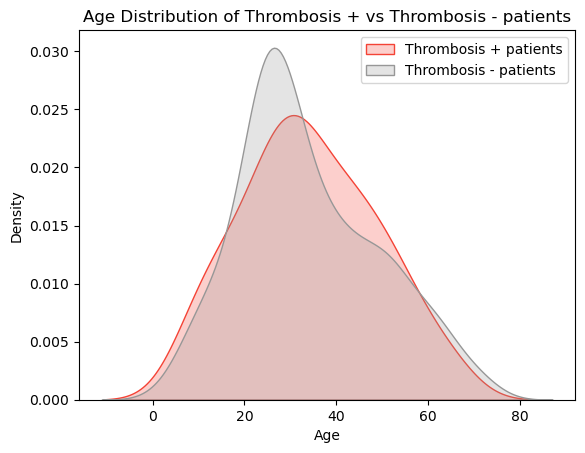

In [24]:
# Create an age_at_examination column 
# Fill NA values with 0 that will be dropped later on
analytic_1['age_at_examination'] = (np.round(((pd.to_datetime(analytic_1['examination_date']) - pd.to_datetime(analytic_1['birthday'])).dt.days / 365), 0)).fillna(0).astype(int)


thrombosis_patients = analytic_1[analytic_1['thrombosis'] != 0]
no_thrombosis_patients = analytic_1[analytic_1['thrombosis'] == 0]

age_t = thrombosis_patients['age_at_examination']
age_nt = no_thrombosis_patients['age_at_examination']

# Filter outliers
age_t = age_t[age_t >2]
age_nt = age_nt[age_nt >2]

# Age distribution plot
sns.kdeplot(age_t, color="#f44336",fill=True, label="Thrombosis + patients")
sns.kdeplot(age_nt, color="#979797",fill=True, label="Thrombosis - patients")

# Add legend
plt.legend()
plt.title("Age Distribution of Thrombosis + vs Thrombosis - patients")
plt.xlabel("Age")

# Display plot
plt.show()


The density plot above shows that Thrombosis does not seem to occur with older/younger people. In fact, most of Thrombosis patients' age are in the range 20-60, which is pretty much the same as that of petients that did not have Thrombosis. The only slight difference is that patients with no thromboses are slightly skewed to the younger side of that range, but ultimately i dont think this holds any relvance.

Next step is to see if there are any differences within the Thrombosis group, meaning between the different levels of the disease's severity.

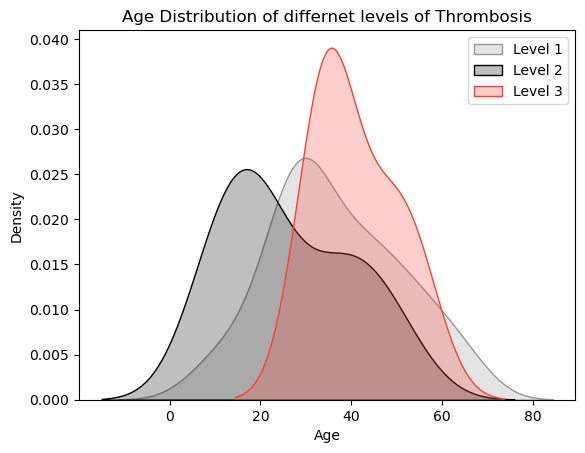

In [25]:
t1 = analytic_1[analytic_1['thrombosis'] == 1]
t1 = analytic_1[analytic_1['thrombosis'] == 1]
t2 = analytic_1[analytic_1['thrombosis'] == 2]
t3 = analytic_1[analytic_1['thrombosis'] == 3]

age_t1 = t1['age_at_examination']
age_t2 = t2['age_at_examination']
age_t3 = t3['age_at_examination']

age_t1 = age_t1[age_t1 > 2]
age_t2 = age_t2[age_t2 > 2]
age_t3 = age_t3[age_t3 > 2]


sns.kdeplot(age_t1, color="#979797",fill=True, label="Level 1")
sns.kdeplot(age_t2, color="black",fill=True, label="Level 2")
sns.kdeplot(age_t3, color="#f44336",fill=True, label="Level 3")

# Add legend
plt.legend()
plt.title("Age Distribution of differnet levels of Thrombosis")
plt.xlabel("Age")

# Display plot
plt.show()

Different levels of Thrombosis turn out to have different age distributions, with the age density plot of level 3 patients being the most condensed in the 35-60 age range, while that of level 1 and level 2 patients being less. 


Next is an analysis on gender

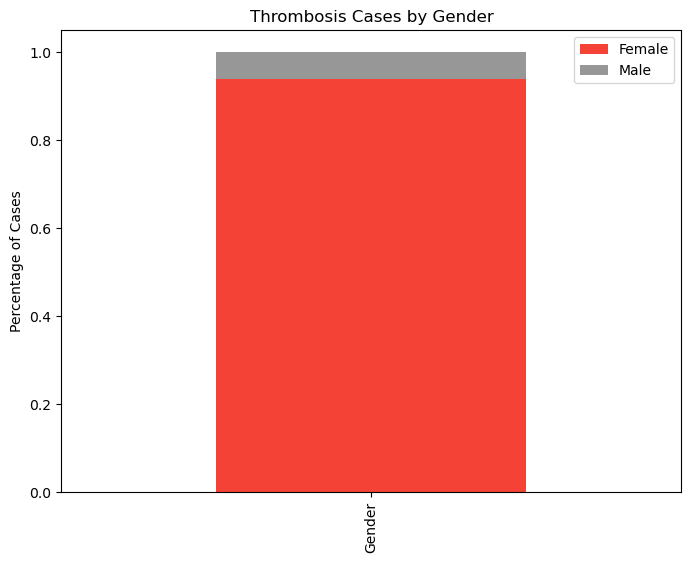

In [26]:
# calculate male and female counts for each dataset
thrombosis_counts = thrombosis_patients['sex'].value_counts()
analytic_counts = analytic_1['sex'].value_counts()

# calculate male and female proportions for each dataset
thrombosis_proportions = thrombosis_counts / thrombosis_counts.sum()
analytic_proportions = analytic_counts / analytic_counts.sum()


# Define the data
gender_data = {'Female': thrombosis_proportions.values[0], 
'Male': thrombosis_proportions.values[1]}

# Convert data to a pandas dataframe
gender_df = pd.DataFrame(gender_data, index=[0])

# Create a stacked bar chart
gender_df.plot(kind='bar', stacked=True, figsize=(8,6), color=['#f44336', '#979797'])

# Add labels and title to the chart

plt.xticks(gender_df.index, ['Gender'])
plt.ylabel('Percentage of Cases')
plt.title('Thrombosis Cases by Gender')

# Show the chart
plt.show()

At first glance, it appears that Thrombosis is dominantly a Female based disease, where the bar chart shows that around 90% of patients in the database that had Thrombosis where females. **However**, this information is extremely misleading without looking at the Gender distribution in the data as a whole (not only Thrombosis + patients).

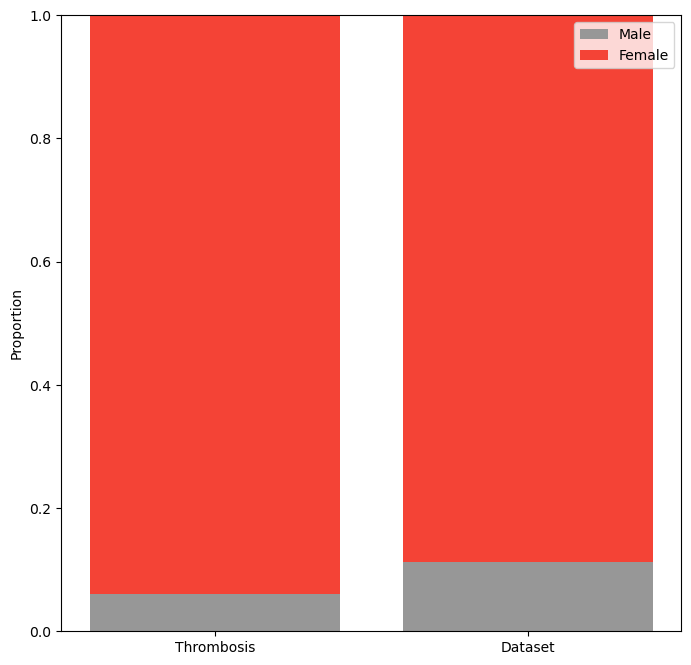

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# calculate male and female counts for each dataset
thrombosis_counts = thrombosis_patients['sex'].value_counts()
analytic_counts = analytic_1['sex'].value_counts()

# calculate male and female proportions for each dataset
thrombosis_proportions = thrombosis_counts / thrombosis_counts.sum()
analytic_proportions = analytic_counts / analytic_counts.sum()

# create a stacked bar chart
fig, ax = plt.subplots(figsize = (8,8))
ax.bar(['Thrombosis', 'Dataset'], [thrombosis_proportions['M'], analytic_proportions['M']],
       label='Male', color='#979797')
ax.bar(['Thrombosis', 'Dataset'], [thrombosis_proportions['F'], analytic_proportions['F']],
       bottom=[thrombosis_proportions['M'], analytic_proportions['M']],
       label='Female', color='#f44336')
max_val = max([thrombosis_proportions.sum(), analytic_proportions.sum()])
ax.set_ylim([0, max_val])
ax.set_ylabel('Proportion')
ax.legend()
plt.show()


As it turns out, the dataset itself is made up of almost all exclusive female patients, which is why Thrombosis appears to be a female dominant disease. This highlights a huge flaw and imbalance in the data, as there is no objective way to analyze whether gender is significant in the Thrombosis conversation.

Next, understanding the characteristics/side effects of Thrombosis is a stepping stone towards finding potential predictors of Thrombosis. I will start with analyzing the lab test results (those of df_B).

Look at box plots to check for outliers.

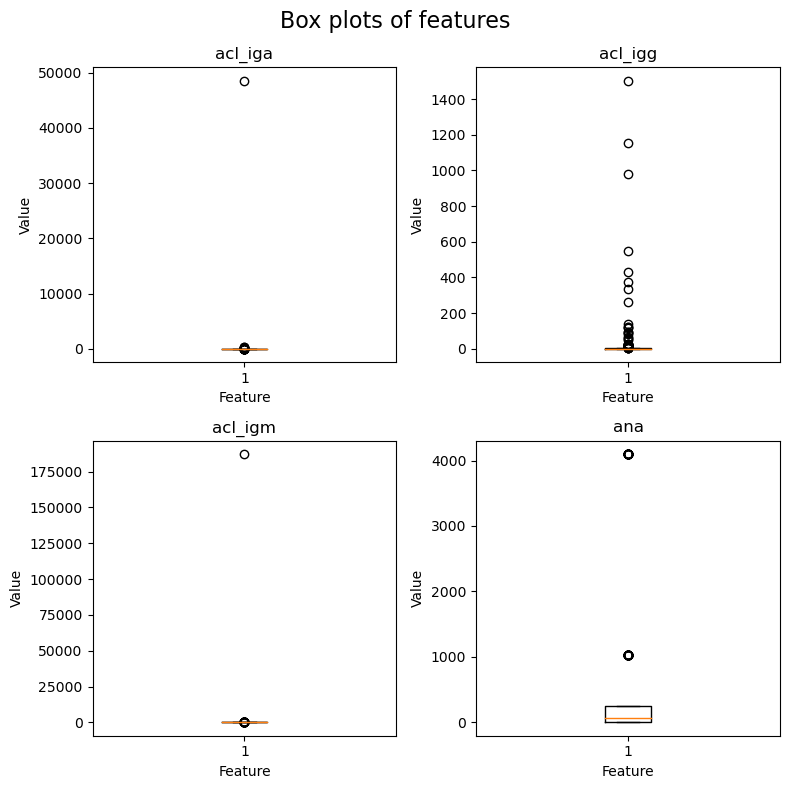

In [28]:
# Subset to columns of interest

lab_results = analytic_1[['acl_iga' , 'acl_igg', 'acl_igm', 'ana', 'thrombosis']]

lab_results = lab_results.dropna(subset=['ana']) # Only 4 missing values 
lab_results['ana'] = lab_results['ana'].astype('int')

# create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# create box plots
# Find the rows containing '>4096'
cols_to_normalize = ['acl_iga' , 'acl_igg', 'acl_igm', 'ana']
mask = (lab_results[cols_to_normalize] == '>4096').any(axis=1)
# Drop the rows containing '>4096'
lab_results = lab_results.drop(index=lab_results[mask].index)
boxp = lab_results[['acl_iga' , 'acl_igg', 'acl_igm', 'ana']].astype(float)
axs[0, 0].boxplot(boxp['acl_iga'])
axs[0, 0].set_title('acl_iga')
axs[0, 1].boxplot(boxp['acl_igg'])
axs[0, 1].set_title('acl_igg')
axs[1, 0].boxplot(boxp['acl_igm'])
axs[1, 0].set_title('acl_igm')
axs[1, 1].boxplot(boxp['ana'])
axs[1, 1].set_title('ana')

# add x-axis label
for ax in axs.flat:
    ax.set_xlabel('Feature')

# add y-axis label
for ax in axs.flat:
    ax.set_ylabel('Value')

# add overall title
plt.suptitle('Box plots of features', fontsize=16)

# adjust layout
plt.tight_layout()

# show plot
plt.show()

The data has a couple of outlier issues.Setting the threshold at 100 for IgA, IgG, and IgM makes sense, while putting it at 200 for ANA also makes sense.

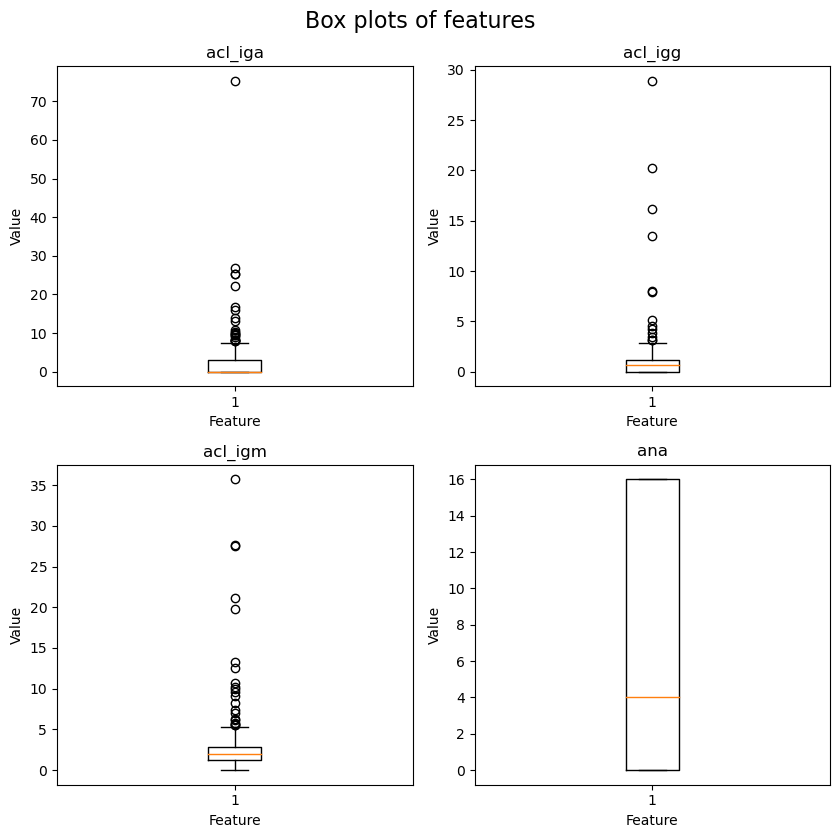

In [29]:
lab_results['ana'] = lab_results['ana'].astype('int')
lab_results = lab_results[(lab_results['acl_iga'] < 100) &  (lab_results['acl_igg'] < 100) &  
(lab_results['acl_igm'] < 100) & (lab_results['ana'] < 50)]


# create subplots
fig, axs = plt.subplots(2, 2, figsize=(8.5, 8.5))

# create box plots
# Find the rows containing '>4096'
cols_to_normalize = ['acl_iga' , 'acl_igg', 'acl_igm', 'ana']
mask = (lab_results[cols_to_normalize] == '>4096').any(axis=1)
# Drop the rows containing '>4096'
lab_results = lab_results.drop(index=lab_results[mask].index)
boxp = lab_results[['acl_iga' , 'acl_igg', 'acl_igm', 'ana']].astype(float)
axs[0, 0].boxplot(boxp['acl_iga'])
axs[0, 0].set_title('acl_iga')
axs[0, 1].boxplot(boxp['acl_igg'])
axs[0, 1].set_title('acl_igg')
axs[1, 0].boxplot(boxp['acl_igm'])
axs[1, 0].set_title('acl_igm')
axs[1, 1].boxplot(boxp['ana'])
axs[1, 1].set_title('ana')

# add x-axis label
for ax in axs.flat:
    ax.set_xlabel('Feature')

# add y-axis label
for ax in axs.flat:
    ax.set_ylabel('Value')

# add overall title
plt.suptitle('Box plots of features', fontsize=16)

# adjust layout
plt.tight_layout()

# show plot
plt.show()


The data now is in a better state to analyze (a handful of outliers remain). Below is a radar chart that shows how patients that do not have Thrombosis compare to those who have (and the different levels) in terms of lab results (averaged results).

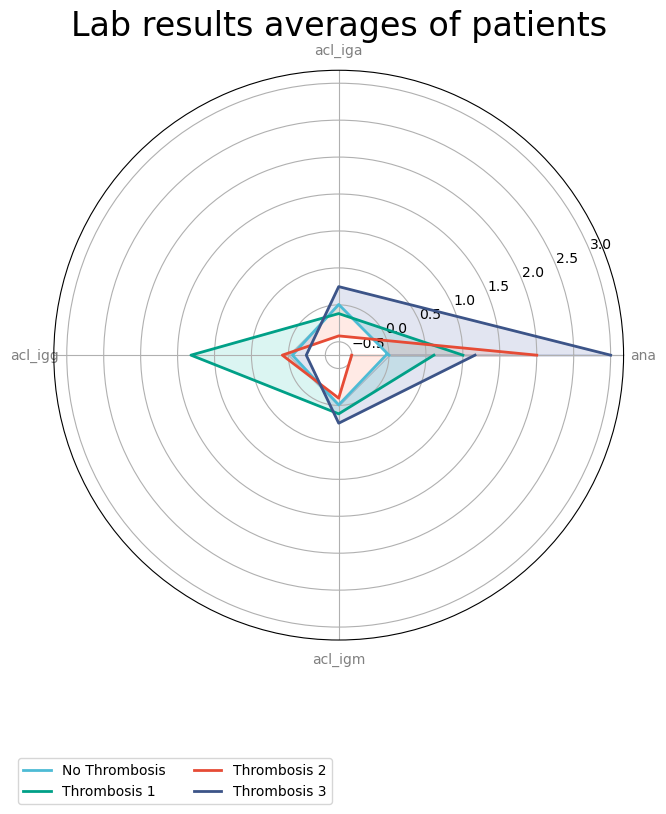

In [30]:
# Normalize columns to have them all in the same scale 


from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
cols_to_normalize = [col for col in lab_results.columns if col != 'thrombosis']
lab_results_norm = pd.DataFrame(scaler.fit_transform(lab_results.loc[:, cols_to_normalize]), columns=cols_to_normalize, index=lab_results.index)
lab_results_norm['thrombosis'] = lab_results['thrombosis']

# Get the means of each thrombosis group

means = lab_results_norm.groupby('thrombosis').mean().reset_index()

categories = ['acl_iga', 'acl_igg', 'acl_igm', 'ana']

variable1 = means.iloc[0, :].values
variable2 = means.iloc[1, :].values
variable3 = means.iloc[2, :].values
variable4 = means.iloc[3, :].values

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(variable1))

# Set colors and fill
colors = ['#4DBBD5', '#00A087', '#E64B35', '#3C5488']
fill_colors = ['#8ED4EB', '#4DD0C1', '#FF987D', '#7081BB']


plt.figure(figsize=(8.5, 8.5))
plt.subplot(polar=True)
plt.fill_between(label_loc, variable1, 0, alpha=0.2, color=fill_colors[0])
plt.plot(label_loc, variable1,
         color=colors[0], label='No Thrombosis', linewidth=2)

plt.fill_between(label_loc, variable2, 0, alpha=0.2, color=fill_colors[1])
plt.plot(label_loc, variable2,
         color=colors[1], label='Thrombosis 1', linewidth=2)

plt.fill_between(label_loc, variable3, 0, alpha=0.2, color=fill_colors[2])
plt.plot(label_loc, variable3,
         color=colors[2], label='Thrombosis 2', linewidth=2)

plt.fill_between(label_loc, variable4, 0, alpha=0.2, color=fill_colors[3])
plt.plot(label_loc, variable4,
         color=colors[3], label='Thrombosis 3', linewidth=2)


plt.title('Lab results averages of patients', size=24)

lines, labels = plt.thetagrids(np.degrees(label_loc), labels=[
                               ''] + categories, color='gray')

                               

plt.legend(loc='lower right' , bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.tight_layout()
plt.show()


The radar chart shows that the only lab results that show significant differences between different Thrombosis groups are:

* ANA: The higher the ANA value the more severe the Thrombosis diagnosis.
* ACL_IGG: Thrombosis level 1 seems to have, on average, the highest acl_igg values among all groups. The fact that people with no Thrombosis and Thrombosis levels 2 and 3 have pretty close acl_igg values is weird but nevertheless, it shows some potential predictive power for Level 1 diagnosis.

It will be important to to the same kind of analysis with the other lab results in df_C later on.



A possible predictor of Thrombosis could be the symptoms a patient is experiencing.


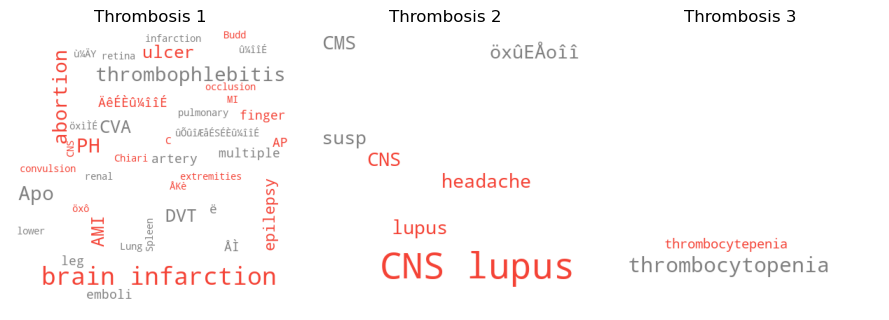

In [31]:
from wordcloud import WordCloud, STOPWORDS
import random
import matplotlib.pyplot as plt


# Read original dataset again
B = pd.read_csv("data/TSUMOTO_B.csv" ,  encoding='ISO-8859-1')

# Define the thrombosis categories to iterate over
thrombosis_categories = [1, 2, 3]

# Create a figure with three columns
fig, axes = plt.subplots(1, 3, figsize=(9, 6))

# Iterate over the thrombosis categories and plot a word cloud in each column
for i, thrombosis_category in enumerate(thrombosis_categories):

    thrombosis_p = B[B['Thrombosis'] == thrombosis_category]

    # Concatenate all the strings in the "Symptoms" column into a single string
    text = ' '.join(thrombosis_p['Symptoms'])

    # Create a set of stopwords
    stopwords = set(STOPWORDS)
    stopwords.update(['Thrombosis', 'ë¦ÄêÉÈû¼îîÉÅÌ', 'öxîîÉ',
                      'ë¦ÄêÉÈû¼îîÉ ÅÌ ', 'ÅKè´ù¼ÄY', 'Budd-Chiari', 'ë¦ÄêÉÈû¼îîÉÅÌ', 'ÅKè´ù¼ÄY'])  # Excluding thrombsosis (obvious word) + some words that dont make sense

    # Define the color palette
    custom_colors = ['#808080', '#F44336']
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return random.choice(custom_colors)

    # Create a WordCloud object with the custom color palette
    wordcloud = WordCloud(width=400, height=400, background_color='white',
                          color_func=color_func, stopwords=stopwords).generate(text)

    # Plot the word cloud in the corresponding subplot
    ax = axes[i]
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(f"Thrombosis {thrombosis_category}")

# Adjust the layout of the figure and display it
plt.tight_layout()
plt.show()


The main side effects of each thrombosis level are the following:

* Level 1: Brain infarction
* Level 2: CNS lupus
* Level 3: Thrombocytopenia

The world clouds also highlight a major issue in the data previously mentioned, the lack of Thrombosis patients, which is why there are fewer and fewer words as the level of Thrombosis is more severe.


The next step is understanding the relationship Thrombosis has with the general lab tests' results and if there are any possible predictors over there.

The most rational thing to do would be analyzing if there are any correlations between the lab results and Thrombosis. Since we are dealing with correlations between numerical variables and a categorical variable, point-biseral will be used to get that correlation.

**Note**: Missing values will be replaced with the column's mean. If more time was given for the project, maybe other data imputation methods could be have been explored.

Below is a correlation heatmap that visualizes the correlation of all lab results in the third database with "Thrombosis". The rationale behind such a plot would be identifying which lab results are highly correlated with Thrombosis, indicating potential predictive power.

**Assumption**: All thrombosis levels were combnied to one category (2 --> 1 , 3 --> 1), since there are very few cases overall, building a predictive model one category of Thrombosis would make more sense.

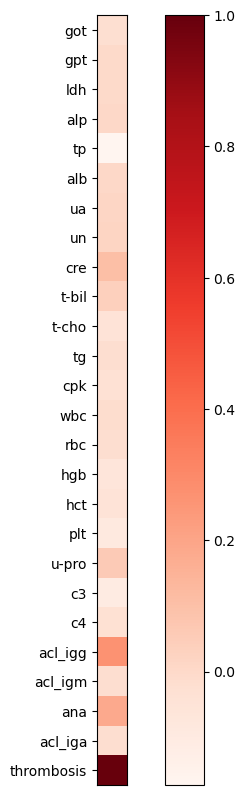

In [32]:
from scipy import stats


# Drop duplicate id and keep last entry, which is the most recent lab test

analytic_2 = analytic_2.drop_duplicates(subset=['id'], keep='last')

# Keep numeric columns to calculate pb correlation

numerical_cols = ['got', 'gpt', 'ldh', 'alp', 'tp', 'alb', 'ua', 'un',
       'cre', 't-bil', 't-cho', 'tg', 'cpk', 'wbc', 'rbc', 'hgb', 'hct', 'plt',
       'u-pro', 'c3', 'c4','acl_igg',
       'acl_igm', 'ana', 'acl_iga', 'thrombosis']

# Fill NA with -1 to convert all columns to numeric (will be dropped later)
for i in numerical_cols:
       analytic_2[i].fillna(value=-1, inplace=True)

analytic_2_numeric = analytic_2[numerical_cols]
analytic_2_numeric = analytic_2[numerical_cols].apply(pd.to_numeric, errors='coerce')

analytic_2_numeric = analytic_2_numeric.astype(float)
analytic_2_numeric = analytic_2_numeric.replace(-1, np.nan)  # Replace -1 with NaN
col_avg = analytic_2_numeric.mean().astype(float)
analytic_2_numeric = analytic_2_numeric.fillna(col_avg)  # Fill NaN values with column averages
analytic_2_numeric['thrombosis'] = analytic_2_numeric['thrombosis'].replace({2: 1, 3: 1}) # Combine all thrombosis cases into 1 category
analytic_2_numeric['thrombosis'] = analytic_2_numeric['thrombosis'].astype('int')

columns = []
correlations = []
# Compute the point-biserial correlation coefficient for each numerical column
for column in analytic_2_numeric.select_dtypes(include='number'):
    # Skip columns that have NaN values
    if analytic_2_numeric[column].isnull().values.any():
        print(f'Skipping column {column} because it has NaN values')
        continue
    
    # Compute the correlation coefficient and p-value, even if there are NaNs
    x = analytic_2_numeric[column].values
    y = analytic_2_numeric['thrombosis'].values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    corr, p_value = stats.pearsonr(x, y)
    
    columns.append(column)
    correlations.append(corr)

correlationsdf = pd.DataFrame({'Variable':columns , 'Correlation with Thrombosis':correlations})


# Visualize correlationsdf

# create an array of values
values = np.array(correlationsdf['Correlation with Thrombosis'].values)

# create a colormap
cmap = plt.cm.get_cmap('Reds')

# create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(10, 10))

# plot the heatmap (transposed)
heatmap = ax.imshow(values.reshape(1, -1).T, cmap=cmap)

# remove the x-axis and set the y-axis ticks to the middle of each bin
ax.set_xticks([])
ax.set_yticks(np.arange(values.size))
ax.set_yticklabels(correlationsdf['Variable'].values)

# add colorbar legend
cbar = fig.colorbar(heatmap)

# show the plot
plt.show()

The heatmap above clearly highlights how none of the lab result variables are significantly correlated with whether or not a person has Thrombosis, making almost all the dataset irrelevant when it comes to further understanding the disease. The only variables that have some sort of correlation are acl_igg and ana (both in the 0.2-0.4 range), and both come from df_B, making the third dataset even more useless.


# Technical Summary 

Suprisingly, the data provided for this analysis much lower in quality than expected, especially since it is coming from such a presigious institution. The main issues i found with the data provided are:

* Missing Values: Missing values is a very serious issue with this data, especiialy in tsumto_c, which had almost half the columns/features in the dataset having more than 80% missing values. This issue was the main obstacle in terms of trying to further understand Thrombosis and its relationship with the general lab tests. There could be some important relationships and patterns that were not deciphered because of this issue.

* Lack of Thrombosis cases: This research project's main focus was understanding Thrombosis at a deeper level and uncovering patterns in the data that could serve has predictors to this disease. However, the data provided barely has any Thrombosis cases, especially more severe ones (levels 2 and 3), making any analysis very sensitive to the addition of larger number of cases.

* Imbalanced Data: Dataset tsumoto_b was highly imbalanced, with almost all patients (around 85%) being females, which could lead to inaccurate conclusions that Thrombosis occurs much more frequently with females (When sampling to thrombosis + cases only is done). A proper analysis on gender could not be conducted because of this.          

* Dates: There is a **huge** difference between the dates patients are testing for thrombosis and their lab tests, with some of them having more than a 5 year difference. This makes any analysis on lab results (tsumoto_c) very weak considering the patients' actual results would have been very different if they had more recent (closer to Thrombosis examination) lab tests.

However, it is important to mention that all the data was collected between the years 1989 and 1996 where the data collection methods were not the most advanced and discrepancies in data was common in the industry. A better idea would be conducting an analysis on thrombosis using more recent data if available.

In terms of main findings, they are the following (elaborated more in results.html):

* Level 3 Thrombosis appears to happen with people on the higher end of the age distirbution.
* ANA and aCl_igG seem to be the lab results that **could** have the most predictive power.
* Different levels of Thrombosis are accompanied with different sets of symptoms.


# Final Results


<figure>
  <img src="Final-plots/age_distribution.png" alt="Thrombosis Age Distribution">
  <figcaption style="color:black; text-align:center; margin-left: 10px;">Figure 1: Distribution of age among thrombosis patients.</figcaption>
</figure>

Figure 1 illustrates that the most severe cases of Thrombosis (Level 3) tend to occur with people in the age range 35-55, which is a bit more than the age
ranges of people that have less severe cases of Thrombosis. This might indicate that the age of a patient could have a say of the Thrombosis level they are diagnosed with, but probably is not powerful enough to conclude if a person has Thrombosis or not. In other words, if patient A has Thrombosis, age might tell us whether he has level 1, 2, or 3 Thrombosis. However, if patient A comes in to test for Thrombosis without prior knowledge if they have the disease, then their age might not be indicative of anything.

<br><br><br><br><br>
<figure>
  <img src="Final-plots/radar.png" alt="Lab Results per Thrombosis Level">
  <figcaption style="color:black; text-align:center; margin-left: 10px;">Figure 2: Average lab results per Thrombosis level.</figcaption>
</figure>

In terms of the special lab tests conducted at the Laboratory of Collagen Diseases, Figure 2 strongly suggests that ana and acl_igg are good indicators of whether a person has Thrombosis. The plot shows that the higher a patient's degree of Thrombosis is, the higher that patient's ANA values are (on average). As for aCL IgG, it is much higher for people with Level 1 Thrombosis than all other cases, with that value dropping as the degree of severity increases. If more tests were provided in a proper dataset, maybe additional relevant features could have been found. <br><br>

<figure>
  <img src="Final-plots/word_clouds.png" alt="Word Clouds">
  <figcaption style="color:black; text-align:center; margin-left: 10px;">Figure 3: Most prevalent symptoms per Thrombosis level.</figcaption>
</figure>


Figure 3 shows that different levels of Thrombosis are accompanied by different sets of symptoms that are prevalent for each group. Specifically:

* Brain infarction is the most dominant symptom for Thrombosis Level 1 patients.
* CNS lupus is the most dominant symptom for Thrombosis Level 2 patients.
* Throbocytopenia is the most dominant symptom for Thrombosis Level 3 patients.

Patients that come into a clinic with any of these symptoms could provide an initial guess as to which Thrombosis level they might have, however more data (with higher quality) is needed to validate this claim.


<figure>
  <img src="Final-plots/heatmap.png" alt="Correlation Heatmap">
  <figcaption style="color:black; text-align:center; margin-left: 10px;">Figure 4: Correlation of lab test results with Thrombosis.</figcaption>
</figure>

Finally, Figure 4 indicates that only 2 of the Laboratory tests that were provided data for are possible predictors of Thrombosis, ANA and aCL IgG. This figure uses different mathematical techniques to validate what was concluded by Figure 1, which further validates the idea that there could be lab tests being carried out that have the potential to predict the possibility of a patient getting Thrombosis.

# Conclusion

Overall, this research project has highlighted two crucial points. Firstly, thrombosis can potentially be predicted using routine lab tests carried out at hospitals on a daily basis. If this claim is further examined and proven true, it could save thousands of lives from this severe disease. Secondly, despite the limited and low-quality data provided, this study has improved our understanding of thrombosis, and there is clear potential for even more discoveries.

Although my work does not provide a definitive solution for predicting or preventing thrombosis, it serves as a stepping stone towards securing proper funding, obtaining more and better quality data, and building a larger team of scientists to further explore the promising findings of this research.


<a href="https://github.com/anly503/hw2-spring-2023-anthonymoub">Github Repo</a>